# NLP Data Exploration

### Imports 

In [1]:
import re
import unicodedata
import pandas as pd
import nltk #natural language tool kit

from env import user, password, host



### Acquire 

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Prepare

In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt'] #ltgt is html artifact

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#how many hams
df[df.label == "ham"].shape

(4825, 2)

In [6]:
#how many spams
df[df.label == "spam"].shape

(747, 2)

In [7]:
df.label.value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [8]:
#concatenate two diff value counts together
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [9]:
#show counts and ratios
def show_counts_and_ratios(df, column):
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    
    return labels


show_counts_and_ratios(df, 'label')

,n,percent
ham,4825,0.865937
spam,747,0.134063


Let's break the data up into 3 seperate pieces:

- The words that appear in legitimate text messages.
- The words that appear in spam text messages.
- All of the words.

In [10]:
#series of strings
df.text

id
0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5572, dtype: object

In [11]:
#splitting a string into a list
name_parts = "jane janeway".split()

In [12]:
#joining a list/collection of strings into one string take the 
#following form
#delimiter_string.join(collection)
#" ".join(df.text)#now its all one string

In [13]:
#treat the series like a list
#calling clean function and joining everything together
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))


In [14]:
#all words
all_words[0:10]

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la']

Once we have a list of words, we can transform it into a pandas Series, which we can then use to show us how often each of the words occurs.

In [15]:
#value counts on each one of these
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()
#most frequent spam words
spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [16]:
#most frequent ham words
ham_freq.head()

im      449
get     314
go      273
ok      272
dont    257
dtype: int64

Now we'll combine these three together to get one resulting data frame that we can work with:



In [17]:
#taking in three diff df will give you one df
#adding left to right
#stitching and sorting
#adding column headers
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int))) #superfluous

word_counts.tail()

,all,ham,spam
zoe,2,1,1
zogtorius,1,1,0
zoom,1,1,0
zouk,1,0,1
zyada,1,1,0


We can now use this data set to answer some interesting questions:

- What are the most frequently occuring words?

In [18]:
#sort by most frequent
#call looks to be evenly distributed by ham and spam
#spam has the word call in it alot
word_counts.sort_values(by='all', ascending=False).head(10)


,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


- Are there any words that uniquely identify a spam or ham message?


In [19]:
#concatenate them all together
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])

,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


### Visualization

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

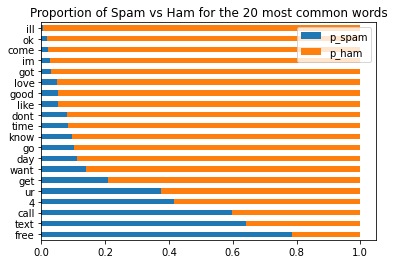

In [21]:
# figure out the percentage of spam vs ham
#taking word counts and making percentages with .assign
#sorting by all words
#labeling labels
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [22]:
#adding the ratio of spam to ham for that particular word
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


* only 15% of our entire dataset is spam

### Word Clouds

python -m pip install --upgrade wordcloud


The wordcloud allows you to identify the relative frequency of different keywords using an easily digestible visual.

Common Use Cases
- As a visualization technique, this method gives a more qualitative analysis of the topics in the documents.

Pros
1. It’s intuitive and easy to comprehend.
2. It helps identify overall respondent sentiment and the specific factors that drive it.
3. It provides direction for further analysis.
Cons
1. It fails to measure each word’s value in and of itself.
2. It allows irrelevant words to appear.
3. When words appear similar in size, it becomes difficult to differentiate them.

First we'll take a look at a simple example:

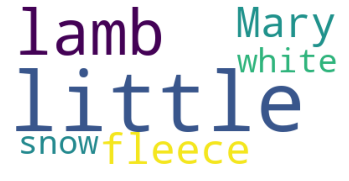

In [24]:
from wordcloud import WordCloud

sentence = 'Mary had a little lamb, little lamb, little lamb. Its fleece was white as snow.'

img = WordCloud(background_color='white').generate(sentence)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show() #to get rid of labels

- dont mess with the pixels
- missing stop words
- stop words not adding meaning they are adding noise, only have meaning to humans

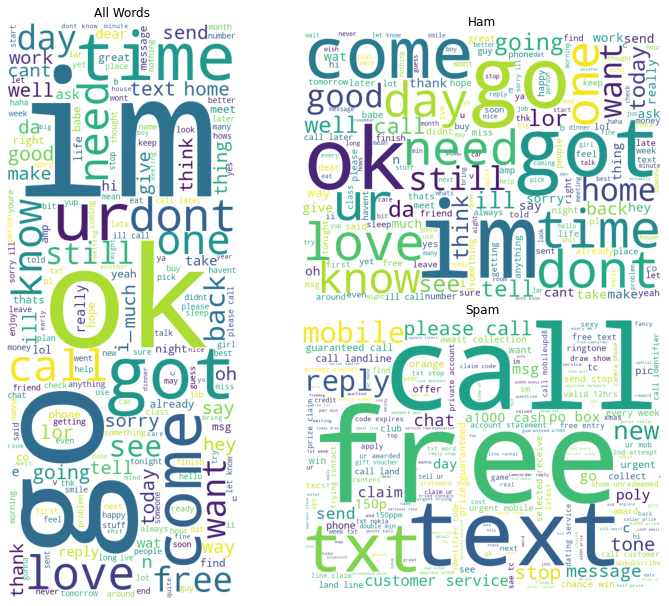

In [25]:
#making the word cloud object
# height and width set so they show
#generate word cloud
#join them into a single string
#axes for words on left and right
#.5 is half of one axis, imshow is how we render an image
#set title is setting titles
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

- these are all single words

### Bigrams

Bigrams are a specific instance of the broader concept of n-grams, which is a way to combine words together. This lets us measure not just the individual word frequency, but also takes into account which words appear together.

To produce the bigrams, we'll use nltk.

- two words that we should tape together because they have more meaning together

In [27]:
#method to get bigram is ngram - meaning however many number of words
#split the string on defalut (space) and putting in the argument of two (bigram)
#every adjacent combination of two things
#could do a trigram by adding 3 instead of 2
sentence = 'Mary had a little lamb'

bigrams = nltk.ngrams(sentence.split(), 2)
list(bigrams)

[('Mary', 'had'), ('had', 'a'), ('a', 'little'), ('little', 'lamb')]

We can apply the same transformation to our ham data set in order to find out which bigrams are the most frequently occuring.

In [28]:
#bigram out of ham words
#turn into series
#then do value counts on that series
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

- bigrams give back tuples, tuple is a list that cant change and denoted by parentheses

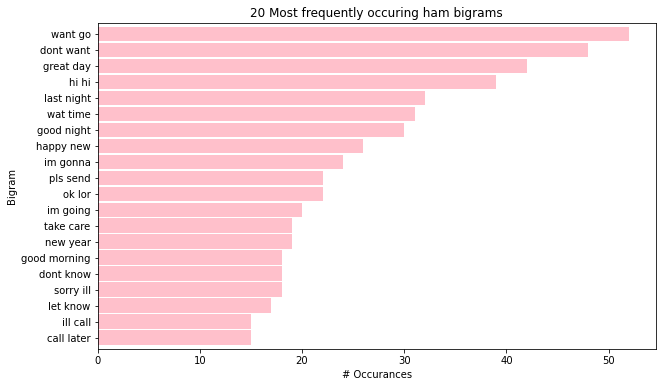

In [29]:
#horizontal bar chart to show value counts of top 20 hambigrams
top_20_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1]) #handling concatenating tuples together, cant actully set an index with a tuple, apply function contatenates tuple
_ = plt.yticks(ticks, labels)

We can use these bigrams to make a word cloud as well, with a little more effort.



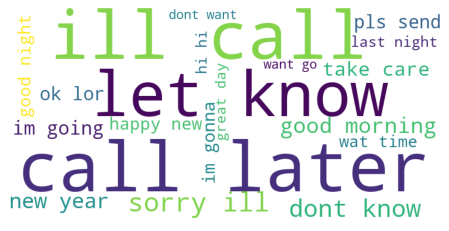

In [30]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.

#dictionary comprehension
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [33]:
def show_freqent_ngram(list_of_strings, n):
    top_20_ngrams = (pd.Series(nltk.ngrams(list_of_strings, n))
                      .value_counts()
                      .head(20))
    top_20_ngrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

    plt.title(f'20 Most frequently occuring {n} -grams')
    plt.ylabel(f'{n}-gram')
    plt.xlabel('# Occurances')

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = top_20_ngrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1]) #broken for now will fix later
    _ = plt.yticks(ticks, labels)
    plt.show()



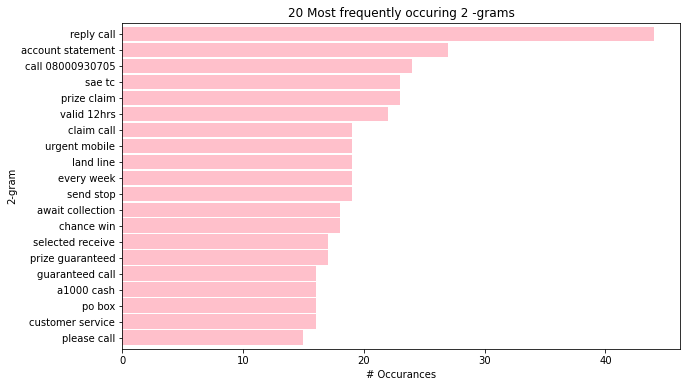

In [35]:
show_freqent_ngram(spam_words, 2)

### Sentiment Analysis

In [ ]:
from nltk.sentiment.vader import Sentiment